# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import warnings


pd.set_option('max_rows', 500), pd.set_option('max_columns', 100), pd.set_option('float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploracion Portfolio

In [3]:
print(f'El archivo tiene {portfolio.shape[0]} observaciones, y {portfolio.shape[1]} variables')
portfolio

El archivo tiene 10 observaciones, y 6 variables


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
channels = ['web', 'mobile', 'email', 'social']
for channel in channels:
    portfolio[f'channel_{channel}'] = portfolio['channels'].apply(lambda x: 1 if channel in str(x) else 0)

portfolio.drop('channels', axis=1, inplace=True)

In [6]:
portfolio.describe(exclude='number')

,offer_type,id
count,10,10
unique,3,10
top,discount,f19421c1d4aa40978ebb69ca19b0e20d
freq,4,1


In [7]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [9]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,channel_web,channel_mobile,channel_email,channel_social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


## Exploracion Profile

In [10]:
profile.head(3).append(profile.tail(2))

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,1970-01-01 00:00:00.020170212,nan
1,F,55,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,112000.00
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,1970-01-01 00:00:00.020180712,nan
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,1970-01-01 00:00:00.020160307,50000.00
16999,F,62,e4052622e5ba45a8b96b59aba68cf068,1970-01-01 00:00:00.020170722,82000.00


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


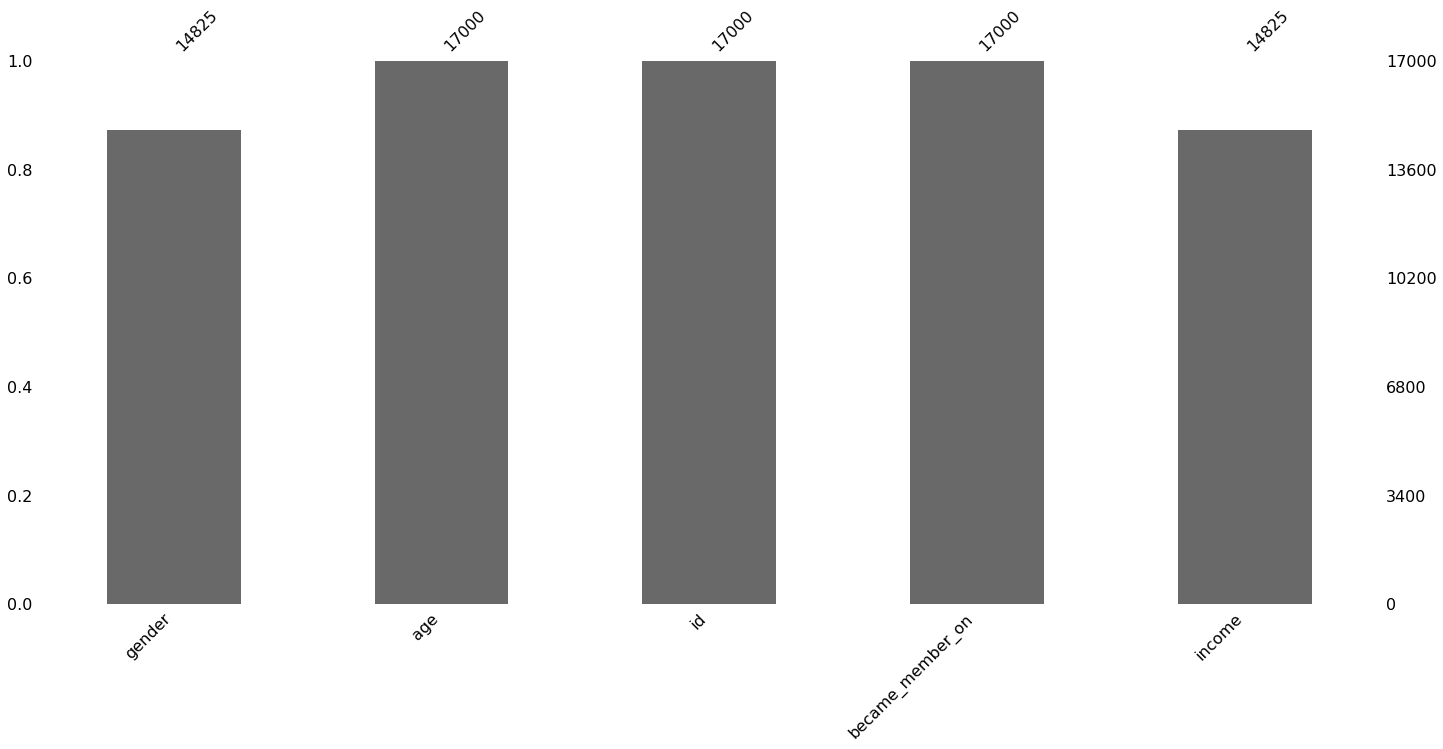

In [12]:
msno.bar(profile)

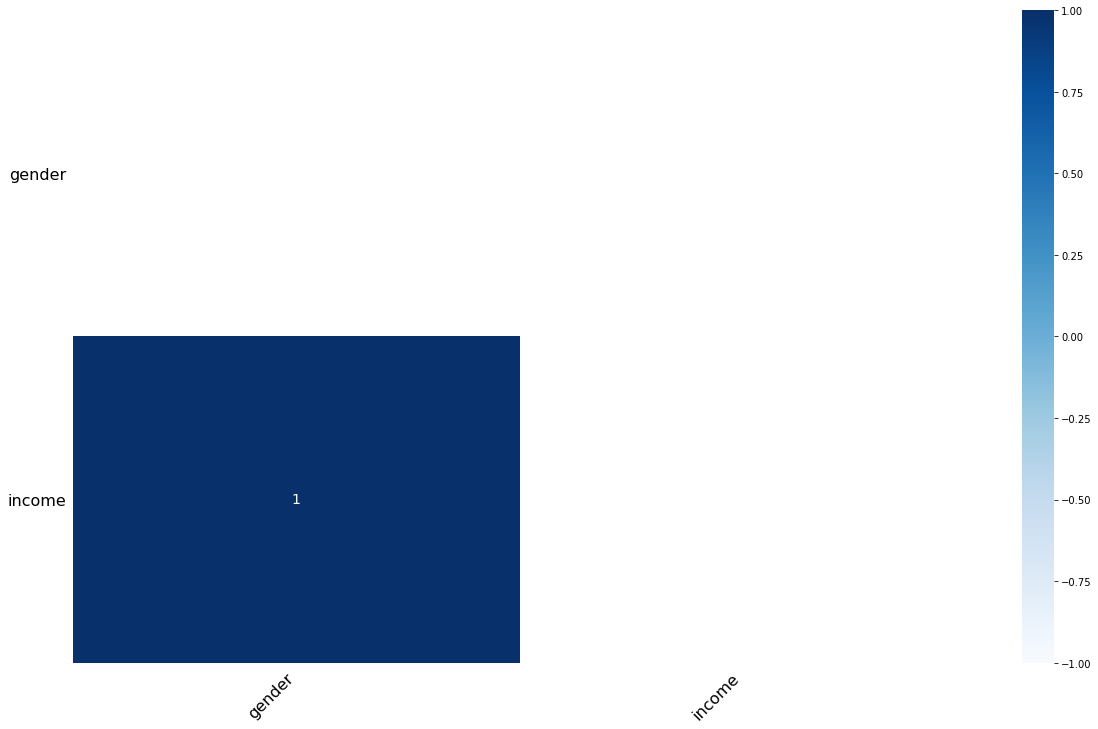

In [13]:
msno.heatmap(profile, cmap='Blues')

In [14]:
profile.describe(exclude='number')

,gender,id,became_member_on
count,14825,17000,17000
unique,3,17000,1716
top,M,941494c5f20a482bbfe46fcb54543d66,1970-01-01 00:00:00.020171207
freq,8484,1,43
first,NaN,NaN,1970-01-01 00:00:00.020130729
last,NaN,NaN,1970-01-01 00:00:00.020180726


In [15]:
profile.describe()

,age,income
count,17000.00,14825.00
mean,62.53,65404.99
std,26.74,21598.30
min,18.00,30000.00
25%,45.00,49000.00
50%,58.00,64000.00
75%,73.00,80000.00
max,118.00,120000.00


In [16]:
indices = profile[profile['gender'].isna()].index.tolist()
profile.drop(indices, axis=0, inplace=True)
profile.rename(columns={'id': 'person_id'}, inplace=True)

In [17]:
profile.describe(exclude='number')

,gender,person_id,became_member_on
count,14825,14825,14825
unique,3,14825,1707
top,M,941494c5f20a482bbfe46fcb54543d66,1970-01-01 00:00:00.020170819
freq,8484,1,39
first,NaN,NaN,1970-01-01 00:00:00.020130729
last,NaN,NaN,1970-01-01 00:00:00.020180726


In [18]:
profile.describe()

,age,income
count,14825.00,14825.00
mean,54.39,65404.99
std,17.38,21598.30
min,18.00,30000.00
25%,42.00,49000.00
50%,55.00,64000.00
75%,66.00,80000.00
max,101.00,120000.00


In [19]:
profile.head(2)

,gender,age,person_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,112000.00
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,1970-01-01 00:00:00.020170509,100000.00


## Exploracion Transcript

In [20]:
transcript.head(3).append(transcript.tail(2))

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [21]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
function = lambda x: x.get('offer_id') if 'offer_id' in x.keys() else (x.get('offer id') if 'offer id' in x.keys() else np.nan)
transcript['offer_id'] = transcript['value'].apply(function)

In [23]:
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount')).fillna(0)

In [24]:
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward'))

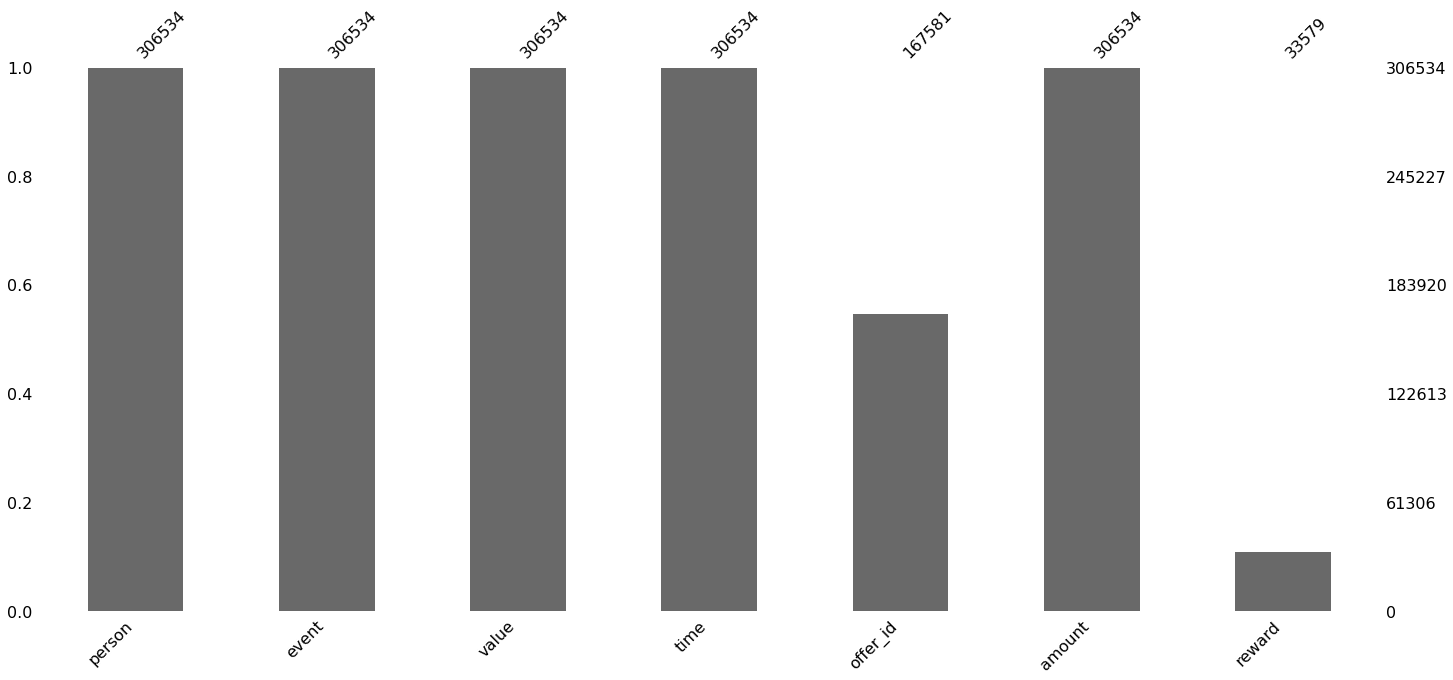

In [25]:
msno.bar(transcript)

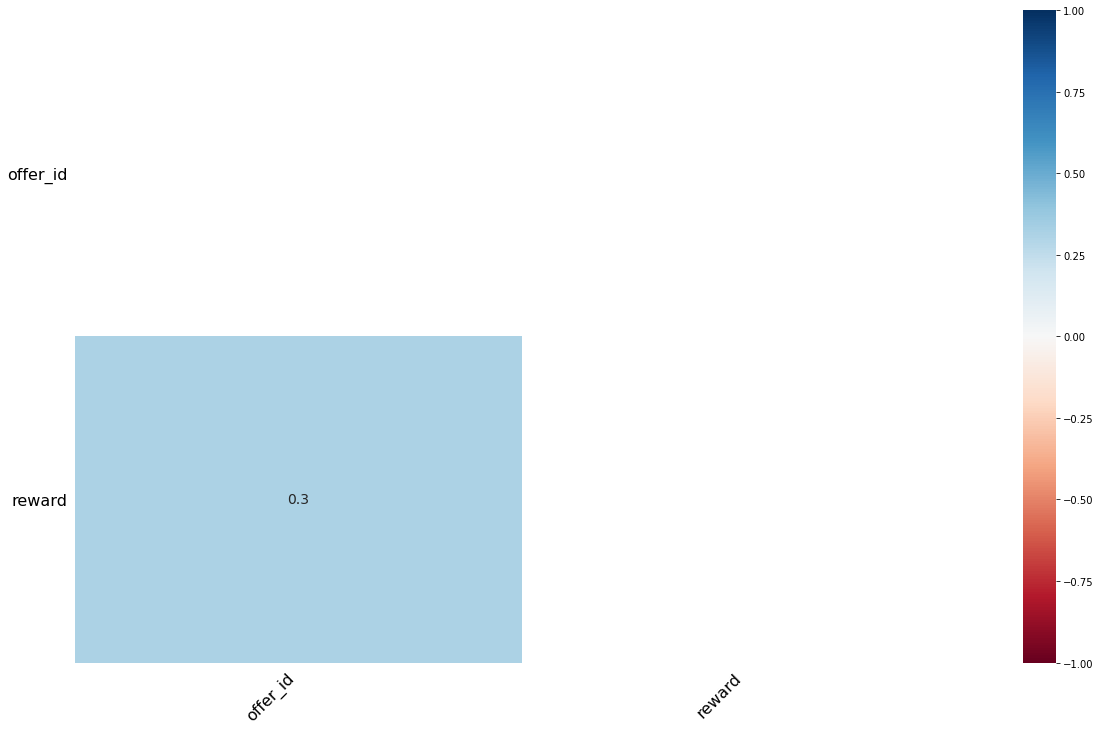

In [26]:
msno.heatmap(transcript)


In [27]:
transcript.head()

,person,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,nan
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,nan
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0.00,nan
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0.00,nan
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,nan


In [28]:
transcript.drop('value', axis=1, inplace=True)
transcript.rename(columns={'person': 'person_id'}, inplace=True)

In [29]:
transcript.describe(exclude='number')

,person_id,event,offer_id
count,306534,306534,167581
unique,17000,4,10
top,94de646f7b6041228ca7dec82adb97d2,transaction,fafdcd668e3743c1bb461111dcafc2a4
freq,51,138953,20241


In [30]:
transcript.describe()

,time,amount,reward
count,306534.00,306534.00,33579.00
mean,366.38,5.79,4.90
std,200.33,21.34,2.89
min,0.00,0.00,2.00
25%,186.00,0.00,2.00
50%,408.00,0.00,5.00
75%,528.00,7.10,5.00
max,714.00,1062.28,10.00


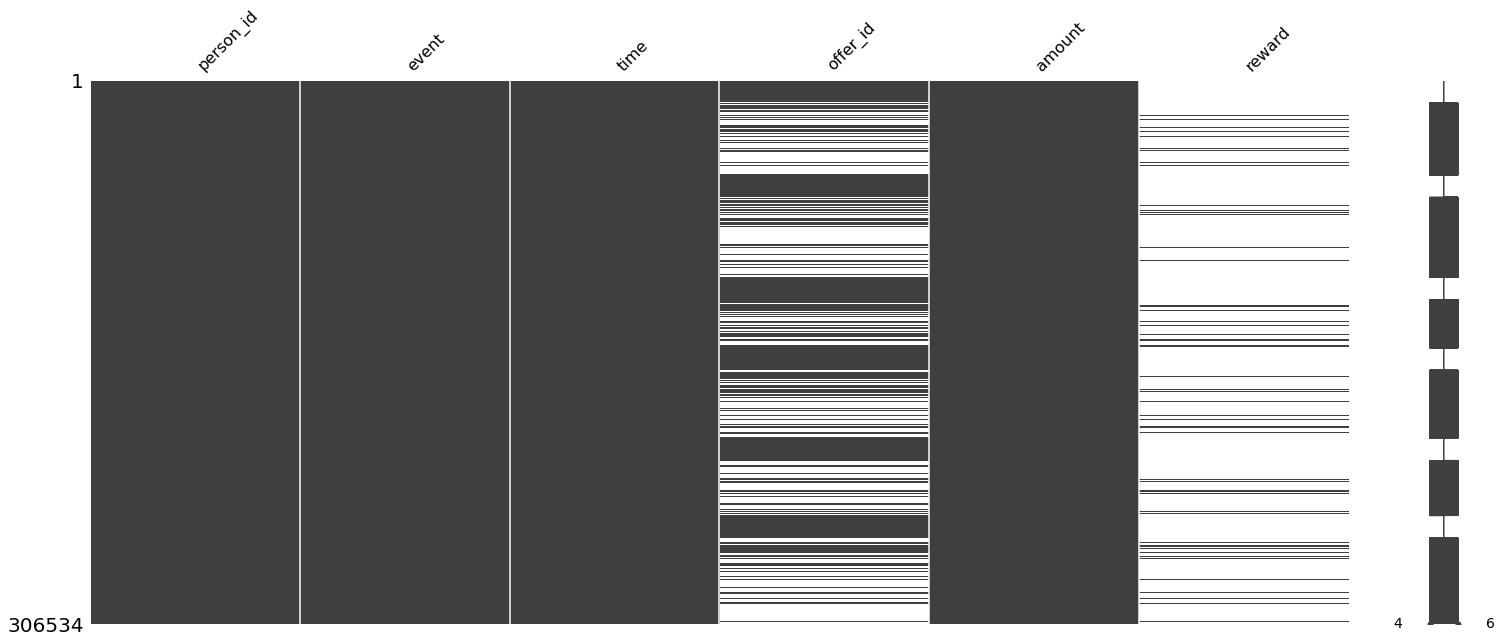

In [31]:
msno.matrix(transcript)

In [32]:
transcript.head(2)

,person_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,nan
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,nan


In [33]:
dataframe = pd.merge(left=transcript,
                     right=profile,
                     how='left',
                     on='person_id').merge(right=portfolio, how='left', on='offer_id')
print(f'El conjunto de datos tiene {dataframe.shape[0]} observaciones, y {dataframe.shape[1]}')

El conjunto de datos tiene 306534 observaciones, y 18


In [34]:
dataframe.head(3).append(dataframe.tail(3))

,person_id,event,time,offer_id,amount,reward_x,gender,age,became_member_on,income,reward_y,difficulty,duration,offer_type,channel_web,channel_mobile,channel_email,channel_social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,nan,F,75.00,1970-01-01 00:00:00.020170509,100000.00,5.00,5.00,7.00,bogo,1.00,1.00,1.00,0.00
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,nan,NaN,nan,NaT,nan,5.00,20.00,10.00,discount,1.00,0.00,1.00,0.00
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.00,nan,M,68.00,1970-01-01 00:00:00.020180426,70000.00,2.00,10.00,7.00,discount,1.00,1.00,1.00,0.00
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,nan,F,63.00,1970-01-01 00:00:00.020130922,52000.00,nan,nan,nan,NaN,nan,nan,nan,nan
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,nan,M,57.00,1970-01-01 00:00:00.020160709,40000.00,nan,nan,nan,NaN,nan,nan,nan,nan
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,NaN,4.05,nan,NaN,nan,NaT,nan,nan,nan,nan,NaN,nan,nan,nan,nan


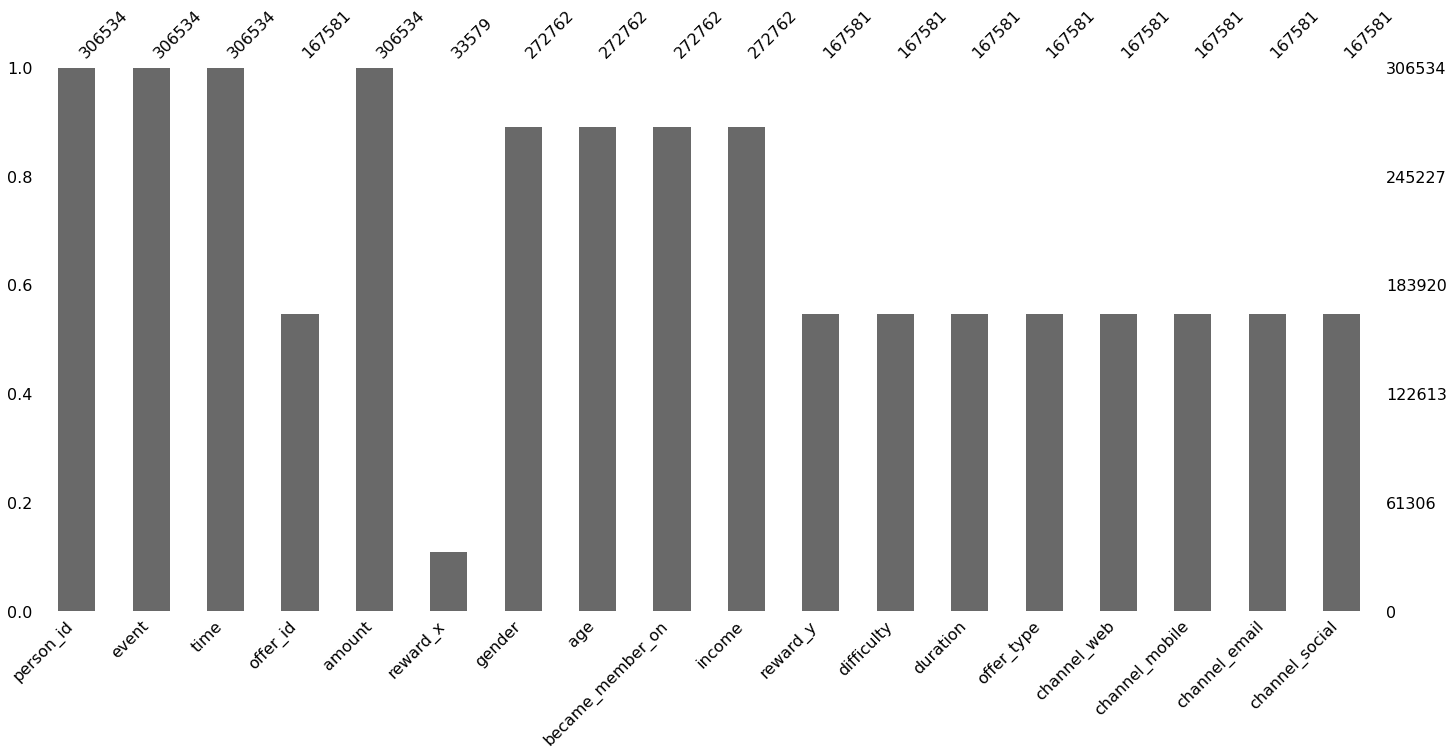

In [35]:
msno.bar(dataframe)

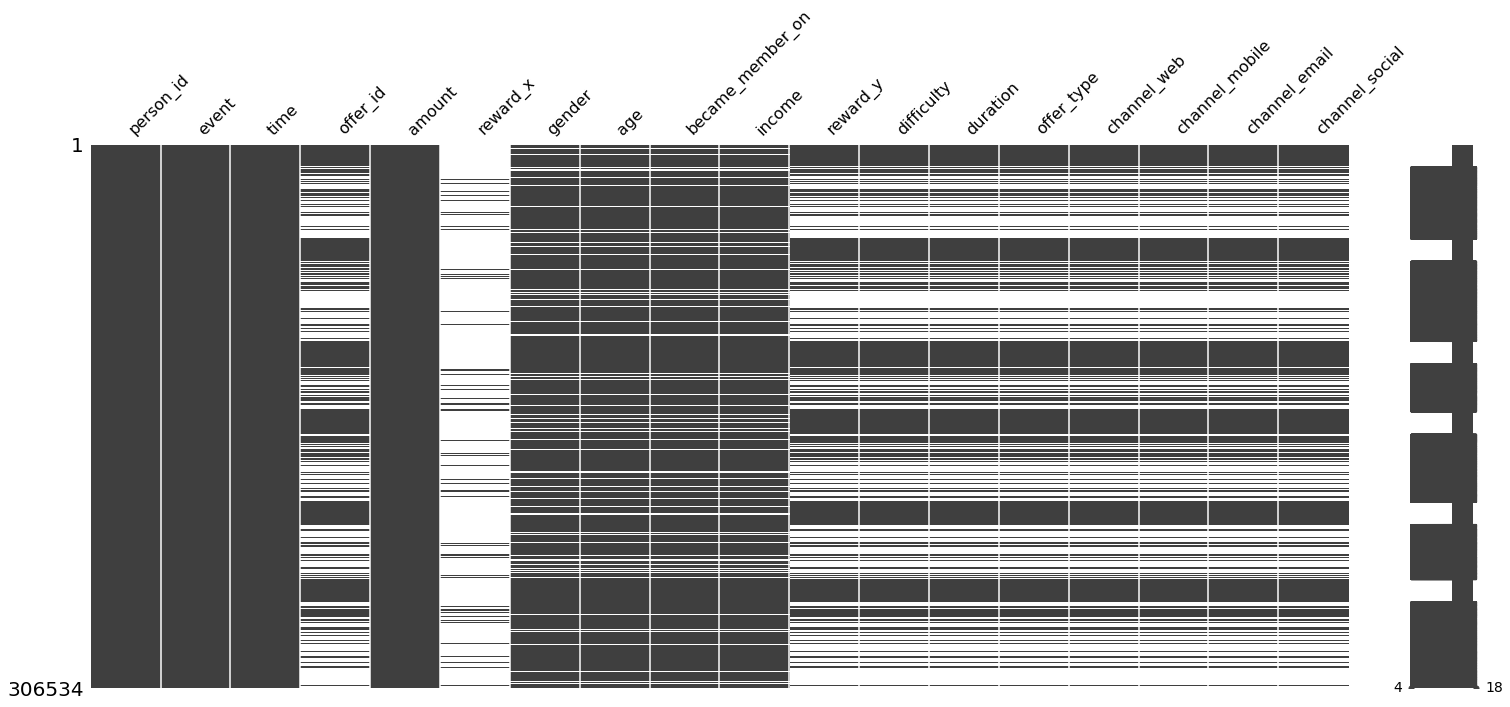

In [36]:
msno.matrix(dataframe)

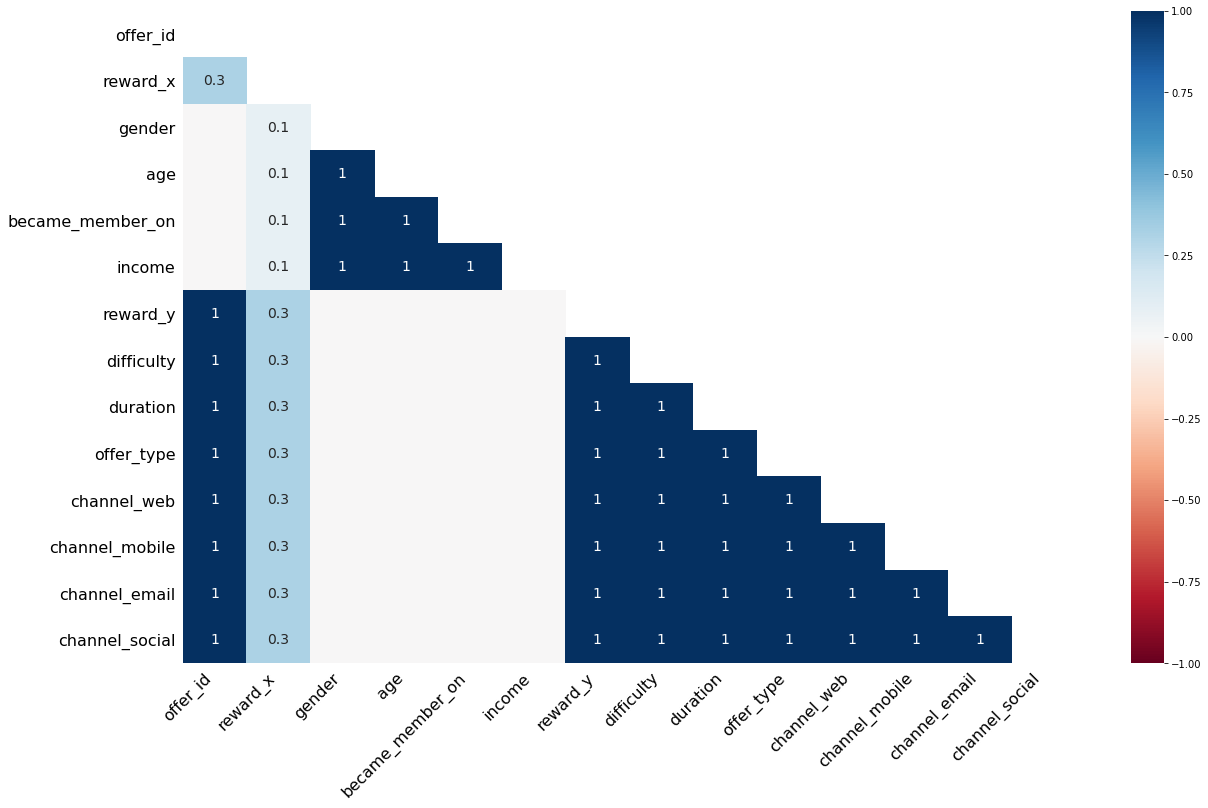

In [37]:
msno.heatmap(dataframe)

In [38]:
dataframe.columns

Index(['person_id', 'event', 'time', 'offer_id', 'amount', 'reward_x',
       'gender', 'age', 'became_member_on', 'income', 'reward_y', 'difficulty',
       'duration', 'offer_type', 'channel_web', 'channel_mobile',
       'channel_email', 'channel_social'],
      dtype='object')

In [39]:
test = dataframe.loc[((dataframe['reward_x'].notna()) & (dataframe['reward_y'].notna())),
                     ['reward_x', 'reward_y']]

In [40]:
test['reward_x'].equals(test['reward_y'])

True

In [41]:
values = [0, 2, 3, 5, 10]
reward = []
for x, y in zip(dataframe['reward_x'].values.tolist(), dataframe['reward_y'].values.tolist()):
    if x in values and y in values:
        reward.append(x)
    elif x not in values and y in values:
        reward.append(y)
    elif x in values and y not in values:
        reward.append(x)
    else:
        reward.append(np.nan)

dataframe['reward'] = reward

In [42]:
dataframe[['reward_x', 'reward_y', 'reward']].head(10).append(dataframe[['reward_x', 'reward_y', 'reward']].tail(10))

,reward_x,reward_y,reward
0,nan,5.00,5.00
1,nan,5.00,5.00
2,nan,2.00,2.00
3,nan,2.00,2.00
4,nan,10.00,10.00
5,nan,5.00,5.00
6,nan,3.00,3.00
7,nan,0.00,0.00
8,nan,5.00,5.00
9,nan,5.00,5.00


In [43]:
dataframe.drop(['reward_x', 'reward_y'], axis=1, inplace=True)
dataframe.head(2)

,person_id,event,time,offer_id,amount,gender,age,became_member_on,income,difficulty,duration,offer_type,channel_web,channel_mobile,channel_email,channel_social,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,F,75.00,1970-01-01 00:00:00.020170509,100000.00,5.00,7.00,bogo,1.00,1.00,1.00,0.00,5.00
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,NaN,nan,NaT,nan,20.00,10.00,discount,1.00,0.00,1.00,0.00,5.00


In [44]:
dataframe.describe(exclude='number')

,person_id,event,offer_id,gender,became_member_on,offer_type
count,306534,306534,167581,272762,272762,167581
unique,17000,4,10,3,1707,3
top,94de646f7b6041228ca7dec82adb97d2,transaction,fafdcd668e3743c1bb461111dcafc2a4,M,1970-01-01 00:00:00.020171207,bogo
freq,51,138953,20241,155690,635,71617
first,NaN,NaN,NaN,NaN,1970-01-01 00:00:00.020130729,NaN
last,NaN,NaN,NaN,NaN,1970-01-01 00:00:00.020180726,NaN


In [45]:
dataframe.describe()

,time,amount,age,income,difficulty,duration,channel_web,channel_mobile,channel_email,channel_social,reward
count,306534.00,306534.00,272762.00,272762.00,167581.00,167581.00,167581.00,167581.00,167581.00,167581.00,167581.00
mean,366.38,5.79,53.84,64337.00,7.85,6.61,0.81,0.92,1.00,0.66,4.42
std,200.33,21.34,17.55,21243.76,5.05,2.14,0.39,0.27,0.00,0.47,3.37
min,0.00,0.00,18.00,30000.00,0.00,3.00,0.00,0.00,1.00,0.00,0.00
25%,186.00,0.00,41.00,48000.00,5.00,5.00,1.00,1.00,1.00,0.00,2.00
50%,408.00,0.00,55.00,62000.00,10.00,7.00,1.00,1.00,1.00,1.00,5.00
75%,528.00,7.10,66.00,78000.00,10.00,7.00,1.00,1.00,1.00,1.00,5.00
max,714.00,1062.28,101.00,120000.00,20.00,10.00,1.00,1.00,1.00,1.00,10.00
